<a href="https://colab.research.google.com/github/manny-uncharted/Face-Recognition/blob/main/Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/manny-uncharted/Face-Recognition.git

Cloning into 'Face-Recognition'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (59/59), 101.94 MiB | 6.13 MiB/s, done.


In [2]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.6 MB/s eta 0:00:00


In [3]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [5]:
!pip install facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00


In [7]:
print(os.listdir("Face-Recognition/training_set/"))

['Greg', '.ipynb_checkpoints', 'Esther', 'John', 'Ben', 'Felicita', 'Fred']


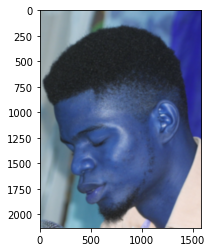

(2132, 1585, 3)


In [8]:
img = cv2.imread('Face-Recognition/training_set/Greg/A1.jpg')
plt.imshow(img, cmap='gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

2/2 [==============================] - 0s 57ms/step


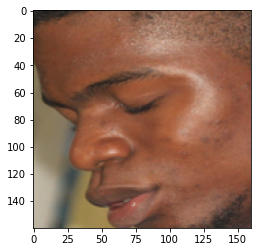

(160, 160, 3)


In [9]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('Face-Recognition/training_set/Greg/A1.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [10]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [11]:
# load train dataset
trainX, trainy = load_dataset('Face-Recognition/training_set/')
print(trainX.shape, trainy.shape)

1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 164ms/step
loaded 3 sample for class: Greg
loaded 0 sample for class: .ipynb_checkpoints
1/1 [==============================] - 0s 180ms/step


10/10 [==============================] - 0s 11ms/step
loaded 3 sample for class: Esther
1/1 [==============================] - 0s 235ms/step
loaded 3 sample for class: John
3/3 [==============================] - 0s 4ms/step
loaded 3 sample for class: Ben
1/1 [==============================] - 0s 159ms/step
loaded 3 sample for class: Felicita
1/1 [==============================] - 0s 242ms/step
loaded 3 sample for class: Fred
(18, 160, 160, 3) (18,)


In [12]:
testX, testy = load_dataset('Face-Recognition/testing_set/')
print(testX.shape, testy.shape)

1/1 [==============================] - 0s 118ms/step
loaded 4 sample for class: Greg
loaded 0 sample for class: .ipynb_checkpoints
10/10 [==============================] - 0s 3ms/step
loaded 4 sample for class: Esther
1/1 [==============================] - 0s 116ms/step
loaded 4 sample for class: John
1/1 [==============================] - 0s 219ms/step
loaded 4 sample for class: Ben
1/1 [==============================] - 0s 118ms/step
loaded 4 sample for class: Felicita
1/1 [==============================] - 0s 119ms/step
loaded 4 sample for class: Fred
(24, 160, 160, 3) (24,)


In [14]:
# save and compress the dataset for further use
np.savez_compressed('faces-dataset.npz', trainX, trainy, testX, testy)
        

In [15]:
# load the face dataset
data = np.load('faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (18, 160, 160, 3) (18,) (24, 160, 160, 3) (24,)


In [ ]:
# load the facenet model
facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')

In [ ]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)